# 4. 測定結果の振り返りと測定計画

長期測定の結果はどの程度正確に推測することができるようになったでしょうか？ここではこれまでの測定結果をまとめつつ、今後の測定計画及び結果の解釈に役立ててください。

In [91]:
# @title 4.0.1. 必要設定の読み込み

#スクリプト実行に必要なパッケージ。
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit,minimize
from scipy.stats import poisson,norm
from scipy import integrate

#用いる関数を定義
def sig(x, a, m, s):#ガウシアン
    if a<0 or s<0:
        return 1e99
    return a*np.exp(-0.5*(x-m)**2/s**2)

def bg(x, b, beta):#exponential
    return b*np.exp(-x/beta)

def bgFull(x, a, m, s, b, beta):
    return sig(x,a,m,s)+bg(x,b,beta)

def sigFull(x, a, m, s, b, beta, scale,a2,m2,s2):
    return scale*bgFull(x,a,m,s,b,beta)+sig(x,a2,m2,s2)


def lin(x,a,b):
    return a*x+b

def dlin(x,a,b,dx,da,db):#直線フィッティングの誤差導出用関数
    dy=(x*da)**2
    dy+=(dx*a)**2
    dy+=db**2
    dy=np.sqrt(dy)
    #print("{:10.4f}, {:10.4f}, {:10.4f}".format((x*da),dx*a,db))
    return dy

def significance(n, b, sigma): #有意性を返す式
    return (n-b)/np.sqrt(b+sigma**2)

def prob(Z):#有意性を「観測した事象より大きく予想から外れる確率」に解釈しなおす式
    return 1-(norm.cdf(Z)-norm.cdf(-Z))

def rebin(x,y,ndiv=3):
    bins = len(x)-1
    # ndiv
    assert bins%ndiv == 0
    bins_new = int(bins/ndiv)
    print(bins_new)
    dx=x[1]-x[0]
    x_new = np.linspace(x[0],x[-1], bins_new+1)
    y_new = np.array([np.sum(y[i*ndiv:(i+1)*ndiv]) for i in range(bins_new+1)])
    return x_new, y_new

def N_to_lambda(N,p):
    func=lambda x: (poisson.cdf(N,x[0])-p)**2
    res=minimize(func,(N*2),method='BFGS')
    tmp = 1.0
    print(res.hess_inv)
    hess_inv_i = res.hess_inv[0][0]
    ftol = 2.220446049250313e-09
    error = np.sqrt(max(1, abs(res.fun)) * ftol * hess_inv_i)
    #print(res.success)
    #print(res.message)
    #for i in range(0,N+1):
      #print("{:2d} {:.2e}".format(i,100*poisson.pmf(i,res.x[1])))
    return res.x[0],error

def pathToTime(path):
  time_format='"%Y-%m-%d" "%H:%M:%S"'
  temp = np.genfromtxt(path, skip_header=1025,skip_footer=1,dtype=str)
  start_text=temp[0]+' '+temp[1]
  start_time=datetime.datetime.strptime(start_text, time_format)
  end_text=temp[2]+' '+temp[3]
  end_time=datetime.datetime.strptime(end_text, time_format)
  Time=(end_time-start_time).seconds
  return Time


def dtheta(theta,ds1=3,ds2=3,L1=58.3):
  #L1=58.3#mm
  L2=1.7#mm
  L3=60#mm
  flag=1
  alpha=-1*flag#cos(agnle) on target
  beta=1*flag#cos(angle) on sensor
  gamma=1*flag#cos(angle) on radiation source
  #ds1=3#mm, window size behind the target
  #ds2=3#mm, window size behind the sensor
  dsi=5#mm, window size of radiation source

  theta_orig=theta
  theta_orig=np.radians(theta_orig)

  vL12=np.array([0,0,L1+L2])
  vdL12=np.array([alpha*np.cos(np.pi/6),0,alpha*np.sin(np.pi/6)])
  vdL12*=ds1*(L1+L2)/L1
  vdLi=np.array([dsi*gamma,0,0])
  vLI=vL12+vdL12-vdLi

  vL3=np.array([-L3*np.sin(theta_orig),0,L3*np.cos(theta_orig)])
  vdL3=np.array([ds2*beta*np.sin(theta_orig),0,ds2*beta*np.cos(theta_orig)])
  vLO=vL3+vdL3-vdL12
  print("設定角度{:.3f} 流入ベクトル角度{:.3f} 散乱ベクトル角度{:.3f} 散乱しない粒子の流入が可能か{:b}".format(theta,np.degrees(np.arctan(vLI[0]/vLI[2])),np.degrees(np.arctan(vLO[0]/vLO[2])),np.degrees(np.arctan(vLI[0]/vLI[2]))<np.degrees(np.arctan(vLO[0]/vLO[2]))))
  if np.degrees(np.arctan(vLI[0]/vLI[2]))<np.degrees(np.arctan(vLO[0]/vLO[2])):
    return theta
  thetap=np.arccos(np.dot(vLI,vLO)/np.sqrt(np.dot(vLI,vLI)*np.dot(vLO,vLO)))
  print("最小入射角度{:.3f}".format(np.degrees(thetap)))
  return abs(np.degrees(thetap)-theta)

#使用例
n=110
dn=4.3
b=50
sigma=np.sqrt(dn**2+b)
print("背景事象数 {:.2f} +/- {:.2f} と推測されるとき、{:d}回より大きく予想が外れる確率{:.2f}σ={:.2e}%".format(b,sigma,n,significance(n,b,sigma),prob(significance(n,b,sigma))*100))
print("信号事象発見に必要な有意性5σ={:.2e}%".format(prob(5)*100))
print("3σ={:.2e}%".format(prob(3)*100))
print("2σ={:.2e}%".format(prob(2)*100))
print("1σ={:.2e}%".format(prob(1)*100))

背景事象数 50.00 +/- 8.28 と推測されるとき、110回より大きく予想が外れる確率5.51σ=3.55e-06%
信号事象発見に必要な有意性5σ=5.73e-05%
3σ=2.70e-01%
2σ=4.55e+00%
1σ=3.17e+01%


In [2]:
# @title 4.0.2. Googleドライブのマウント(オプション)

#実験データなど、Googleドライブにあるファイルにアクセスしたい場合に実行する。自分のアカウントで要認証。ダミーデータで取り組む場合は実行不要
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 4.1. 結果の読み込みと計画

適宜ファイルを追加することで、以下のプロットを利用できます。

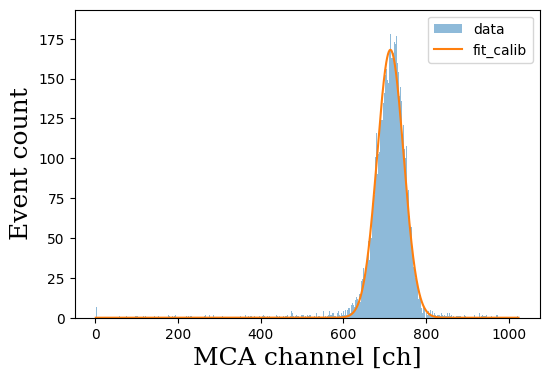

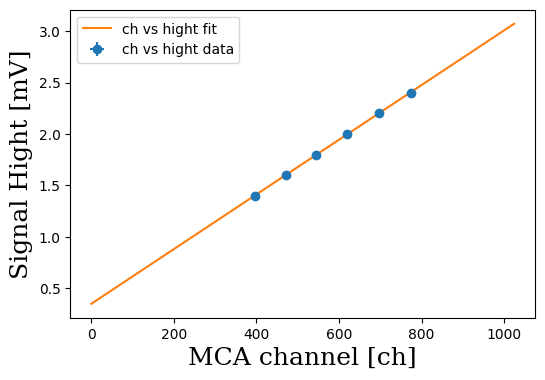

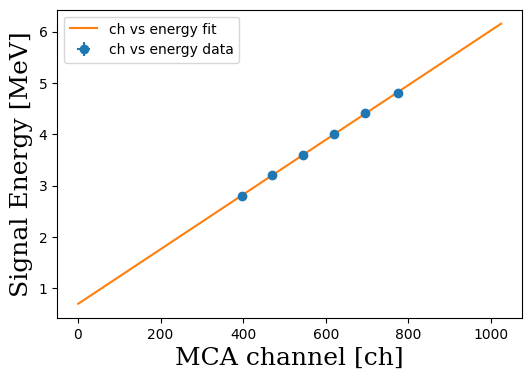

f(E4p5 [ch])= 4.500 +/- 0.026 [MeV]
f(E0 [ch])= 0.000 +/- 0.024 [MeV]
            Estimate  Std. error
Constant   63.123070    0.576845
Mean      230.809347    0.480024
Sigma      63.742188    0.356863
            Estimate  Std. error
Constant  902.619132    8.408518
Mean      653.623850    0.328116
Sigma      41.678306    0.224012
Al通過後のアルファ線のエネルギー :    1.924 +/-    0.018 MeV
Au 通過後のアルファ線のエネルギー :    4.178 +/-    0.025 MeV
        Estimate  Std. error
Slope   4.542685    0.128205
Offset -2.285549    0.422323
        Estimate  Std. error
Slope   1.771394    0.038742
Offset -0.107500    0.127620
ターゲットに入射する信号強度=1135.0 +/-    9.5 [Bq]
ターゲットから線源までの見込み角= 5.770e-03 [sr]
Al厚さdx=     12.16 +/-       0.50 [um]
Au厚さdx=      0.71 +/-       0.21 [um]
キャリブレーションを行った時間=  63[sec]
[[280.42602946]]
測定された背景事象数　1.00　測定時間　2.72e+03
推定されたlambda*t=4.74e+00+/-7.89e-04->lambda=1.75e-03+/-2.91e-07
設定角度20.000 流入ベクトル角度-7.479 散乱ベクトル角度-15.478 散乱しない粒子の流入が可能か0
最小入射角度8.000
測定数　110.00 測定時間300.00
推定背景事象数　5.24e-01+/-8.72e-

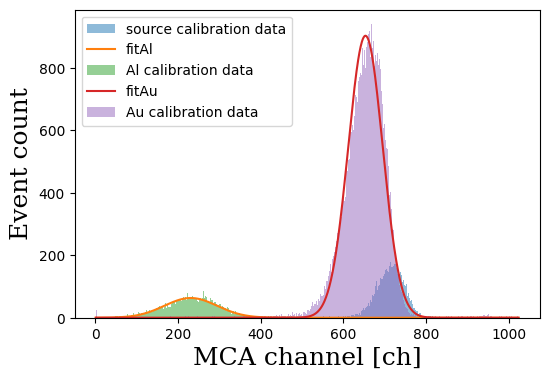

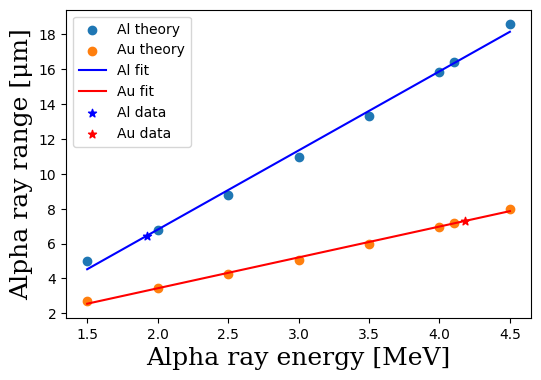

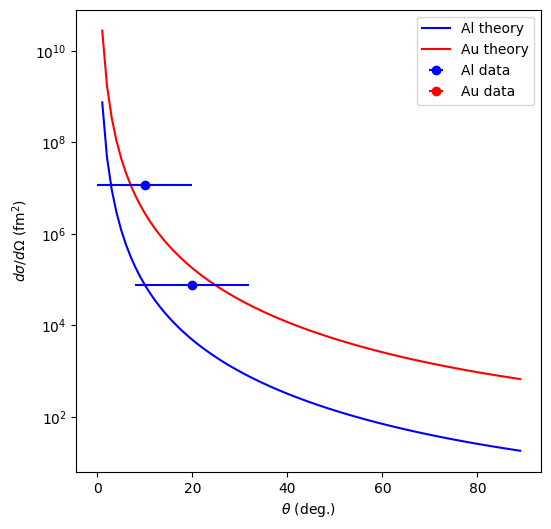

In [92]:
# @title 4.1.1. 情報読み込みとプロット作成

#パルス波ファイル、pathと測定波高を任意の回数入れる
pulse_file_list=[]
pulse_file_list.append(['/content/drive/MyDrive/temp/b3exp/pulse2p4.csv',2.4])
pulse_file_list.append(['/content/drive/MyDrive/temp/b3exp/pulse2p2.csv',2.2])
pulse_file_list.append(['/content/drive/MyDrive/temp/b3exp/pulse2p0.csv',2.0])
pulse_file_list.append(['/content/drive/MyDrive/temp/b3exp/pulse1p8.csv',1.8])
pulse_file_list.append(['/content/drive/MyDrive/temp/b3exp/pulse1p6.csv',1.6])
pulse_file_list.append(['/content/drive/MyDrive/temp/b3exp/pulse1p4.csv',1.4])
#強度測定ファイル
calib_path='/content/drive/MyDrive/temp/b3exp/60sec0degNoTarget.csv'
#厚さ測定ファイル
Aldeg0 = np.genfromtxt('/content/drive/MyDrive/temp/b3exp/60sec0degAl.csv', skip_footer=6)
Audeg0 = np.genfromtxt('/content/drive/MyDrive/temp/b3exp/Au.csv', skip_footer=6)
#背景事象測定ファイル
BG_path='/content/drive/MyDrive/temp/b3exp/dummyBG.csv'
#散乱測定ファイル、pathと測定角度を任意の回数入れる
Al_file_list=[]
Al_file_list.append(['/content/drive/MyDrive/temp/b3exp/300sec20degAl.csv',20])
Al_file_list.append(['/content/drive/MyDrive/temp/b3exp/60sec10degAl.csv',10])
Au_file_list=[]
#Au_file_list.append(['/content/drive/MyDrive/temp/b3exp/Au_30.csv',30])

#以下書き換え不要
x=np.arange(1,1025)#x軸
#強度測定
alpha_calib = np.genfromtxt(calib_path, skip_footer=6)
Tcalib=pathToTime(calib_path)
mean0=np.argmax(alpha_calib)
max0=np.max(alpha_calib)
dy=np.where(alpha_calib > 0, np.sqrt(alpha_calib), 1.0)#誤差は統計誤差の√nのみ,nが0なら0
par_calib, cov_calib = curve_fit(sig, x, alpha_calib, p0=(max0, mean0, 25), sigma=dy)#適切な初期値を与えてフィッティング
perr_calib = np.sqrt(np.diag(cov_calib))#分散共分散行列の対角成分取り出し=分散の取り出し
#plot
fig1 = plt.figure(figsize=(6, 4))
ax = fig1.add_subplot(111)
_ = ax.hist(x, bins=1024, weights=alpha_calib, range=(1, 1024), alpha=0.5, label='data')#全データのヒストグラムを作成
plt.xlabel('MCA channel [ch]', fontsize=18, fontfamily='serif')#x軸の名前
plt.ylabel('Event count', fontsize=18, fontfamily='serif')#y軸の名前
y = sig(x, *par_calib)
_ = ax.plot(x, y, '-', label='fit_calib')
scaling_ch=par_calib[1]
dscaling_ch=perr_calib[1]
plt.legend(loc='upper right')

#変換関数決定
pulse_list=[]
hight=[]
for file_i in pulse_file_list:
  pulse_list.append(np.genfromtxt(file_i[0], skip_footer=6))
  hight.append(file_i[1])
ch = []
dch = []
E = []
dA=10
for hight,pulsar_i in zip(hight,pulse_list):#入力したデータ数分繰り返し
    E=np.append(E,hight)
    y=pulsar_i#1ヒストグラム取り出し
    dy=np.where(y > 0, np.sqrt(y), 1.0)#誤差は統計誤差の√nのみ,nが0なら0
    par_gaus, cov_gaus = curve_fit(sig, x, y, p0=(np.max(y), np.argmax(y), dA),sigma=dy)#適切な初期値を与えてフィッティング
    perr_gaus = np.sqrt(np.diag(cov_gaus))#分散共分散行列の対角成分取り出し=分散の取り出し
    #結果を記録
    ch=np.append(ch,float(par_gaus[1]))
    dch=np.append(dch,float(perr_gaus[1]))
par_line, cov_line = curve_fit(lin, ch, E, sigma=dch)#f(ch+/-dch)=Eを直線(lin)でフィッティング
perr_line = np.sqrt(np.diag(cov_line))#誤差抽出
#plot
y = par_line[0]*x + par_line[1]
fig2 = plt.figure(figsize=(6, 4))
plt.errorbar(ch,E,0,dch,fmt="o",label='ch vs hight data')
plt.plot(x,y,label='ch vs hight fit')
plt.xlabel('MCA channel [ch]', fontsize=18, fontfamily='serif')#x軸の名前
plt.ylabel('Signal Hight [mV]', fontsize=18, fontfamily='serif')#y軸の名前
plt.legend(loc='upper left')
plt.show()
E0=(0-par_line[1])/par_line[0]#E=a*ch+b -> ch=(E-b)/aで、今E=0を求める
dE0=abs((0-par_line[1])/par_line[0]*np.sqrt((perr_line[0]/par_line[0])**2+(perr_line[1]/par_line[1])**2))#b,aにつく誤差をそれぞれ評価
#re-scaling
scaling=par_line[0]*scaling_ch + par_line[1]
#print(scaling)
par_line, cov_line = curve_fit(lin, ch, E/scaling*4.5, sigma=dch)#f(ch+/-dch)=Eを直線(lin)でフィッティング
perr_line = np.sqrt(np.diag(cov_line))#誤差抽出
y = par_line[0]*x + par_line[1]

fig3 = plt.figure(figsize=(6, 4))
plt.errorbar(ch,E/scaling*4.5,0,dch,fmt="o",label='ch vs energy data')
plt.plot(x,y,label='ch vs energy fit')
plt.xlabel('MCA channel [ch]', fontsize=18, fontfamily='serif')#x軸の名前
plt.ylabel('Signal Energy [MeV]', fontsize=18, fontfamily='serif')#y軸の名前
plt.legend(loc='upper left')
plt.show()
#キャリブレーションされた関数で、測定されたチャンネル数から予想されたエネルギーの値が得られるか確認
print("f(E4p5 [ch])= {:5.3f} +/- {:5.3f} [MeV]".format(lin(scaling_ch,par_line[0],par_line[1]),dlin(scaling_ch,par_line[0],par_line[1],dscaling_ch,perr_line[0],perr_line[1])))
print("f(E0 [ch])= {:5.3f} +/- {:5.3f} [MeV]".format(lin(E0,par_line[0],par_line[1]),dlin(E0,par_line[0],par_line[1],dE0,perr_line[0],perr_line[1])))

#厚さ測定
fig4 = plt.figure(figsize=(6, 4))
ax = fig4.add_subplot(111)
_ = ax.hist(x, bins=1024, weights=alpha_calib, range=(1, 1024), alpha=0.5, label='source calibration data')
plt.xlabel('MCA channel [ch]', fontsize=18, fontfamily='serif')#x軸の名前
plt.ylabel('Event count', fontsize=18, fontfamily='serif')#y軸の名前
#Alに関する処理
dy=np.where(Aldeg0 > 0, np.sqrt(Aldeg0), 1.0)
mean0=np.argmax(Aldeg0)
max0=np.max(Aldeg0)
par_Al, cov_Al = curve_fit(sig, x, Aldeg0, p0=(max0, mean0, 50), sigma=dy)
perr_Al = np.sqrt(np.diag(cov_Al))
mat = np.vstack((par_Al,perr_Al)).T
df = pd.DataFrame(mat,index=("Constant", "Mean", "Sigma"), columns=("Estimate", "Std. error"))
print(df)
y = sig(x, *par_Al)
_ = ax.plot(x, y, '-', label='fitAl')
_ = ax.hist(x, bins=1024, weights=Aldeg0, range=(1, 1024), alpha=0.5, label='Al calibration data')
#Auに関する処理
dy=np.where(Audeg0 > 0, np.sqrt(Audeg0), 1.0)
mean0=np.argmax(Audeg0)
max0=np.max(Audeg0)
par_Au, cov_Au = curve_fit(sig, x, Audeg0, p0=(max0, mean0, 50), sigma=dy)
perr_Au = np.sqrt(np.diag(cov_Au))
mat = np.vstack((par_Au,perr_Au)).T
df = pd.DataFrame(mat,index=("Constant", "Mean", "Sigma"), columns=("Estimate", "Std. error"))
print(df)
y = sig(x, *par_Au)
_ = ax.plot(x, y, '-', label='fitAu')
_ = ax.hist(x, bins=1024, weights=Audeg0, range=(1, 1024), alpha=0.5, label='Au calibration data')
plt.legend(loc='upper left')

#Alに関する変換
EAlreco=lin(par_Al[1],par_line[0],par_line[1])
dEAlreco=dlin(par_Al[1],par_line[0],par_line[1],perr_Al[1],perr_line[0],perr_line[1])
print("Al通過後のアルファ線のエネルギー : {:8.3f} +/- {:8.3f} MeV".format(EAlreco,dEAlreco))
#Auに関する変換
EAureco=lin(par_Au[1],par_line[0],par_line[1])
dEAureco=dlin(par_Au[1],par_line[0],par_line[1],perr_Au[1],perr_line[0],perr_line[1])
print("Au 通過後のアルファ線のエネルギー : {:8.3f} +/- {:8.3f} MeV".format(EAureco,dEAureco))
#テキストにある理論値
Ealphatheo=[1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.1, 4.5]#アルファ線のエネルギー
EAltheo=[5.017, 6.804, 8.777, 10.944, 13.308, 15.867, 16.402, 18.618]#Al中の飛程
EAutheo=[2.699, 3.435, 4.230, 5.086, 6.002, 6.974, 7.175, 8.001]#Au中の飛程
#Alに関するフィッティング
par_Al_line, cov_Al_line = curve_fit(lin, Ealphatheo, EAltheo)#アルファ線のエネルギー[MeV]->アルファ線が飛べるAlの厚さ[um]の式をフィッティング
perr_Al_line = np.sqrt(np.diag(cov_Al_line))
mat = np.vstack((par_Al_line,perr_Al_line)).T
df = pd.DataFrame(mat,index=("Slope", "Offset"), columns=("Estimate", "Std. error"))
print(df)
#Auに関するフィッティング
par_Au_line, cov_Au_line = curve_fit(lin, Ealphatheo, EAutheo)#アルファ線のエネルギー[MeV]->アルファ線が飛べるAlの厚さ[um]の式をフィッティング
perr_Au_line = np.sqrt(np.diag(cov_Au_line))
mat = np.vstack((par_Au_line,perr_Au_line)).T
df = pd.DataFrame(mat,index=("Slope", "Offset"), columns=("Estimate", "Std. error"))
print(df)
#プロット
fig5 = plt.figure(figsize=(6, 4))
plt.scatter(Ealphatheo,EAltheo,marker="o",label='Al theory')#理論値Al
plt.scatter(Ealphatheo,EAutheo,marker="o",label='Au theory')#理論値Au
plt.xlabel('Alpha ray energy [MeV]', fontsize=18, fontfamily='serif')#x軸の名前
plt.ylabel('Alpha ray range [μm]', fontsize=18, fontfamily='serif')#y軸の名前
x_funcAl = np.arange(1.5,5.5)
y_funcAl = par_Al_line[0]*x_funcAl + par_Al_line[1]
x_funcAu = np.arange(1.5,5.5)
y_funcAu = par_Au_line[0]*x_funcAu + par_Au_line[1]
plt.plot(x_funcAl,y_funcAl,'b',label='Al fit')
plt.plot(x_funcAu,y_funcAu,'r',label='Au fit')
plt.scatter(EAlreco,par_Al_line[0]*EAlreco+par_Al_line[1],marker="*",color='b',label='Al data')#測定値Al
plt.scatter(EAureco,par_Au_line[0]*EAureco+par_Au_line[1],marker="*",color='r',label='Au data')#測定値Au
RAl=lin(EAlreco,par_Al_line[0],par_Al_line[1])#測定された、残りのエネルギーで飛べるAlの厚さ
dRAl=dlin(EAlreco,par_Al_line[0],par_Al_line[1],dEAlreco,perr_Al_line[0],perr_Al_line[1])#その誤差
dxAl=18.618-RAl#アルファ線が飛んできたAlの厚さ
RAu=lin(EAureco,par_Au_line[0],par_Au_line[1])
dRAu=dlin(EAureco,par_Au_line[0],par_Au_line[1],dEAureco,perr_Au_line[0],perr_Au_line[1])
dxAu=8.001-RAu
plt.legend(loc='upper left')

#計算
drs=6/2 #mm センサー手前のウィンドウ幅
Ss=np.pi*drs**2 #センサー手前のウィンドウ面積
L=130 #mm 線源からセンサーまでの距離
dOmega_RtoS=Ss/L**2 #線源からセンサーまでの見込み角
drt=6/2 #mm ターゲット手前のウィンドウ幅
St=np.pi*drt**2 #センサー手前のウィンドウ面積
Lt=58.3 #mm 線源からターゲット手前のウィンドウまでの距離
dOmega_RtoT=St/Lt**2 #線源からターゲットの見込み角
#オプション課題：ターゲット手前のウィンドウの傾きを考慮するとどうなるか検討する
Ls=70 #mm ターゲットからセンサーまでの距離
dOmega_TtoS=Ss/Ls**2 #ターゲットからセンサーまでの見込み角


#強度計算
Ncalib=np.sum(alpha_calib)#キャリブレーションのデータ測定で得られたイベント数を全て足す
B0=Ncalib/Tcalib*4*np.pi/dOmega_RtoS#線源強度
dB0=np.sqrt(Ncalib)/Tcalib*4*np.pi/dOmega_RtoS#統計誤差
B=B0*dOmega_RtoT/4/np.pi
dB=dB0*dOmega_RtoT/4/np.pi
NA=6.02e23
Al_weight=26.98
Au_weight=196.97
NAl=dxAl*1e-4*2.69*NA/Al_weight #dxAl[cm]*2.69[g/cm^3]*NA[count/mol]/weight[g/mol]
dNAl=dRAl*1e-4*2.69*NA/Al_weight
NAu=dxAu*1e-4*19.3*NA/Au_weight
dNAu=dRAu*1e-4*19.3*NA/Au_weight
z = 2  # alpha は4He 2+
ZAl = 13  # Alの陽子数は13
ZAu = 79  # Auの陽子数は79
hbarc = 197.3
alpha = 1/137.
e2 = hbarc*alpha
E = 4.5
AAl = (z*ZAl*e2/4/E)**2
AAu = (z*ZAu*e2/4/E)**2
print("ターゲットに入射する信号強度={:6.1f} +/- {:6.1f} [Bq]".format(B,dB))
print("ターゲットから線源までの見込み角={:10.3e} [sr]".format(dOmega_TtoS))
print("Al厚さdx={:10.2f} +/- {:10.2f} [um]".format(dxAl,dRAl))
print("Au厚さdx={:10.2f} +/- {:10.2f} [um]".format(dxAu,dRAu))
print("キャリブレーションを行った時間={:4.0f}[sec]".format(Tcalib))

#背景事象評価
bg = np.genfromtxt(BG_path, skip_footer=6)
Tbg=pathToTime(BG_path)
Nbg=np.sum(bg)
lamb,dlamb=N_to_lambda(Nbg,0.05)
print("測定された背景事象数　{:.2f}　測定時間　{:.2e}".format(Nbg,Tbg))
print("推定されたlambda*t={:.2e}+/-{:.2e}->lambda={:.2e}+/-{:.2e}".format(lamb,dlamb,lamb/Tbg,dlamb/Tbg))
lamb/=Tbg
dlamb/=Tbg

fig5 = plt.figure(figsize=(6, 6))
ax = fig5.add_subplot(111)
theta_x=np.arange(1,90)#プロットするx軸のbinを設定
fAl=AAl*(np.sin(np.radians(theta_x)/2))**-4
fAu=AAu*(np.sin(np.radians(theta_x)/2))**-4
ax.plot(theta_x, fAl, 'b-',label='Al theory')
ax.plot(theta_x, fAu, 'r-',label='Au theory')
plt.yscale('log')  # ログスケール
ax.set_xlabel(r'$\theta$ (deg.)')
ax.set_ylabel(r'$d\sigma/d\Omega$ (fm$^2$)')

theta_Al=[]
dtheta_Al=[]
dsdW_Al=[]
for file_i in Al_file_list :
  Al_file=np.genfromtxt(file_i[0], skip_footer=6)
  theta_Al.append(file_i[1])
  dtheta_Al.append(dtheta(file_i[1]))
  Nsig=np.sum(Al_file)
  tmes=pathToTime(file_i[0])
  dsdW_Al.append(Nsig/(B*tmes*NAl*1e-26*dOmega_TtoS))
  print("測定数　{:.2f} 測定時間{:.2f}".format(Nsig,tmes))
  b=lamb*tmes
  db=dlamb*tmes
  print("推定背景事象数　{:.2e}+/-{:.2e}　有意性{:.2f}σ".format(b,db,significance(Nsig,b,db)))
plt.errorbar(theta_Al,dsdW_Al,xerr=dtheta_Al,fmt="o",color="b",label='Al data')#測定値Al

theta_Au=[]
dtheta_Au=[]
dsdW_Au=[]
for file_i in Au_file_list :
  Au_file=np.genfromtxt(file_i[0], skip_footer=6)
  theta_Au.append(file_i[1])
  dtheta_Au.append(dtheta(file_i[1]))
  Nsig=np.sum(Au_file)
  tmes=pathToTime(file_i[0])
  dsdW_Au.append(Nsig/(B*tmes*NAu*1e-26*dOmega_TtoS))
  print("測定数　{:.2f} 測定時間{:.2f}".format(Nsig,tmes))
  b=lamb*tmes
  db=dlamb*tmes
  print("推定背景事象数　{:.2e}+/-{:.2e}　有意性{:.2f}σ".format(b,db,significance(Nsig,b,db)))
plt.errorbar(theta_Au,dsdW_Au,xerr=dtheta_Au,fmt="o",color="r",label='Au data')#測定値Au
plt.legend(loc='upper right')



信号強度 1.14e+03 -> 1.14e+03
推定背景事象数　6.04e+02+/-1.00e-01　測定時間345600.00[sec]
設定角度60.000 流入ベクトル角度-7.479 散乱ベクトル角度-54.712 散乱しない粒子の流入が可能か0
最小入射角度47.233
12.766997209842614
推定測定数　718.26+/-277.65 推定有意性29.23σ


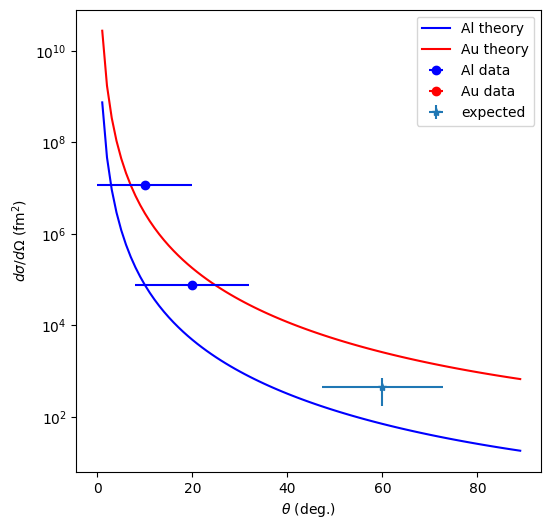

In [103]:
# @title 4.1.2. 計画用
theta_plan=60
t_plan=4*24*60*60
bAl=True
ds1_updated=3
ds2_updated=3
L1_updated=58.3

Ss=np.pi*ds2_updated**2 #センサー手前のウィンドウ面積
dOmega_TtoS=Ss/Ls**2 #ターゲットからセンサーまでの見込み角

B_update=B*(ds1_updated/drt)**2*(L1_updated/L1)**2
print("信号強度 {:.2e} -> {:.2e}".format(B,B_update))

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.plot(theta_x, fAl, 'b-',label='Al theory')
ax.plot(theta_x, fAu, 'r-',label='Au theory')
plt.yscale('log')  # ログスケール
ax.set_xlabel(r'$\theta$ (deg.)')
ax.set_ylabel(r'$d\sigma/d\Omega$ (fm$^2$)')

b=lamb*t_plan
db=dlamb*t_plan
print("推定背景事象数　{:.2e}+/-{:.2e}　測定時間{:.2f}[sec]".format(b,db,t_plan))

dtheta_plan=dtheta(theta_plan,ds1_updated,ds2_updated,L1_updated)
print(dtheta_plan)
if(bAl):
  dsigmadOmegaAl=AAl*(np.sin(np.radians(theta_plan)/2))**-4
  N_expected=B_update*t_plan*NAl*1e-26*dsigmadOmegaAl*dOmega_TtoS+b
  if dtheta==theta_plan:
    dN_expected=0
  else:
    ddsigmadOmegaAl=AAl*(np.sin(np.radians(theta_plan-dtheta_plan)/2))**-4
    dN_expected=B_update*t_plan*NAl*1e-26*ddsigmadOmegaAl*dOmega_TtoS
  dsdW_plan=N_expected/(B_update*t_plan*NAl*1e-26*dOmega_TtoS)
  ddsdW_plan=dsdW_plan-dN_expected/(B_update*t_plan*NAl*1e-26*dOmega_TtoS)
else:
  dsigmadOmegaAu=AAu*(np.sin(np.radians(theta_plan)/2))**-4
  N_expected=B_update*t_plan*NAu*1e-26*dsigmadOmegaAu*dOmega_TtoS+b
  if dtheta==theta_plan:
    dN_expected=0
  else:
    ddsigmadOmegaAu=AAu*(np.sin(np.radians(theta_plan-dtheta_plan)/2))**-4
    dN_expected=B_update*t_plan*NAu*1e-26*ddsigmadOmegaAu*dOmega_TtoS
  dsdW_plan=N_expected/(B_update*t_plan*NAu*1e-26*dOmega_TtoS)
  ddsdW_plan=dsdW_plan-dN_expected/(B_update*t_plan*NAu*1e-26*dOmega_TtoS)


dN_expected=np.sqrt(dN_expected**2+db**2)
print("推定測定数　{:.2f}+/-{:.2f} 推定有意性{:.2f}σ".format(N_expected,dN_expected,significance(N_expected+b,b,db)))

plt.errorbar(theta_Al,dsdW_Al,xerr=dtheta_Al,fmt="o",color="b",label='Al data')#測定値Al
plt.errorbar(theta_Au,dsdW_Au,xerr=dtheta_Au,fmt="o",color="r",label='Au data')#測定値Au
plt.errorbar(theta_plan,dsdW_plan,xerr=dtheta_plan,yerr=ddsdW_plan,fmt="*",label='expected')#推定値
plt.legend(loc='upper right')



# 4.2. 発展的議論

これまでの議論では様々な近似が用いられてきましたが、それらを除去した議論のためのツールです。高度なためレポートに利用する場合はよく理解して自分の言葉で説明できるようにしてください。（利用しなくても減点はありません）
4.2.1.は時間がかかり、またnStepを大きくしすぎると途中で止まることに注意してください。

array([[<Axes: title={'center': 'weight_t'}>,
        <Axes: title={'center': 'dx_r'}>,
        <Axes: title={'center': 'dy_r'}>,
        <Axes: title={'center': 'theta_r'}>],
       [<Axes: title={'center': 'phi_r'}>, <Axes: title={'center': 'X'}>,
        <Axes: title={'center': 'Y'}>, <Axes: title={'center': 'dS'}>],
       [<Axes: title={'center': 'X2'}>, <Axes: title={'center': 'Y2'}>,
        <Axes: title={'center': 'dS2'}>,
        <Axes: title={'center': 'theta_t'}>],
       [<Axes: title={'center': 'phi_t'}>,
        <Axes: title={'center': 'XS'}>, <Axes: title={'center': 'YS'}>,
        <Axes: title={'center': 'dSS'}>],
       [<Axes: title={'center': 'X3'}>, <Axes: title={'center': 'Y3'}>,
        <Axes: title={'center': 'dS3'}>, <Axes: >]], dtype=object)

<Figure size 1800x1800 with 0 Axes>

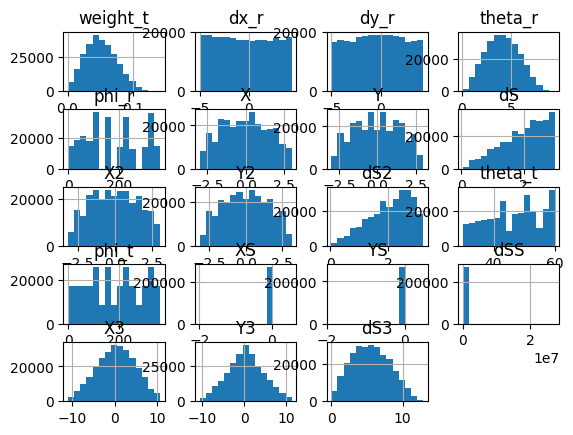

In [64]:
# @title 4.2.1. サンプルデータの作成

#設定パラメタ
theta_mes=np.radians(45)
#計算用パラメタ
L1=58.3#mm
L2=1.7#mm
L3=60#mm
ds1=3#mm, window size behind the target
ds2=3#mm, window size behind the sensor
dsi=5#mm, window size of radiation source

l_data=[]
nStep=15
onedeg=np.pi/1800.
vL1=np.array([0,0,L1])
vL12=np.array([0,0,L1+L2])
vL3=np.array([0,0,L3])

roty_mes = np.array([[ np.cos(theta_mes), 0,  np.sin(theta_mes)],
              [                 0, 1,                  0],
              [-np.sin(theta_mes), 0, np.cos(theta_mes)]])


for dx_r in np.arange(-1*dsi,dsi,10/nStep):
  for dy_r in np.arange(-1*dsi,dsi,10/nStep):
    vdLi=np.array([dx_r,dy_r,0])
    for theta_r in np.arange(0+onedeg, np.pi/18.+onedeg*2,np.pi/18./nStep) :
      roty_r = np.array([[ np.cos(theta_r), 0,  np.sin(theta_r)],
                    [                 0, 1,                  0],
                    [-np.sin(theta_r), 0, np.cos(theta_r)]])
      weight=np.sin(theta_r)
      for phi_r in np.arange(0,2*np.pi+onedeg,2*np.pi/nStep) :
        rotz_r = np.array([[ np.cos(phi_r), -np.sin(phi_r), 0],
                      [ np.sin(phi_r),  np.cos(phi_r), 0],
                      [                 0,                  0, 1]])
        veLI=np.array([0,0,1])
        veLI=rotz_r.dot(roty_r).dot(veLI.T).T
        #veLI=np.array([np.sin(theta_r)*np.cos(phi_r),np.sin(theta_r)*np.sin(phi_r),np.cos(theta_r)])
        #vdLi-vL1+R*veLI
        RatioL1=-1*(-vL1[2]-vdLi[0]/np.sqrt(3))/(veLI[2]-veLI[0]/np.sqrt(3))
        X=vdLi[0]+RatioL1*veLI[0]
        Y=vdLi[1]+RatioL1*veLI[1]
        dS=np.sqrt(X*X+Y*Y)
        if(dS<=ds1):
          RatioL2=-1*(-vL12[2]-vdLi[0]/np.sqrt(3))/(veLI[2]-veLI[0]/np.sqrt(3))
          X2=vdLi[0]+RatioL2*veLI[0]
          Y2=vdLi[1]+RatioL2*veLI[1]
          dS2=np.sqrt(X2*X2+Y2*Y2)
          vdL2=vdLi-vL1+RatioL2*veLI
          RatioL123=(L1+L2+L3)/veLI[2]
          X3=vdLi[0]+RatioL123*veLI[0]
          Y3=vdLi[1]+RatioL123*veLI[1]
          dS3=np.sqrt(X3*X3+Y3*Y3)
          for theta_t in np.arange(theta_mes-np.pi/12, theta_mes+np.pi/12.+onedeg,np.pi/6./nStep/2.) :
            weight_t=weight*np.sin(theta_t)
            roty_t = np.array([[ np.cos(theta_t), 0,  np.sin(theta_t)],
                          [                 0, 1,                  0],
                          [-np.sin(theta_t), 0, np.cos(theta_t)]])
            for phi_t in np.arange(0,2*np.pi+onedeg,2*np.pi/nStep/2.) :
              rotz_t = np.array([[ np.cos(phi_t), -np.sin(phi_t), 0],
                            [ np.sin(phi_t),  np.cos(phi_t), 0],
                            [                 0,                  0, 1]])
              veLO=np.array([0,0,1])
              veLO=rotz_r.dot(roty_r.dot(rotz_t.dot(roty_t))).dot(veLO.T).T
              #vdL2+R*veLO
              vconst=vdL2
              vconst=roty_mes.dot(vconst.T).T
              veLO=roty_mes.dot(veLO.T).T
              RatioLS=(L3-vconst[2])/veLO[2]
              XS=vconst[0]+RatioLS*veLO[0]
              YS=vconst[1]+RatioLS*veLO[1]
              dSS=np.sqrt(XS*XS+YS*YS)
              l_data.append([weight_t,dx_r,dy_r,np.degrees(theta_r),np.degrees(phi_r),X,Y,dS,X2,Y2,dS2,np.degrees(theta_t),np.degrees(phi_t),XS,YS,dSS,X3,Y3,dS3])
fig = plt.figure(figsize=(18, 18))
df_advance = pd.DataFrame(l_data)
df_advance.columns = ["weight_t","dx_r","dy_r","theta_r","phi_r","X","Y","dS","X2","Y2","dS2","theta_t","phi_t","XS","YS","dSS","X3","Y3","dS3"]
df_advance.hist(bins=nStep,weights=df_advance["weight_t"])

weight_t    9.514719e+02
dx_r       -8.676667e+03
dy_r       -4.450000e+03
theta_r     7.532587e+04
phi_r       5.748792e+06
X          -5.144373e+02
Y          -9.042243e+02
dS          6.161125e+04
X2         -2.316282e+02
Y2         -8.009254e+02
dS2         6.200596e+04
theta_t     1.502245e+06
phi_t       5.747004e+06
XS          1.210009e+02
YS          2.023322e+02
dSS         6.305235e+04
X3          7.368981e+03
Y3          2.867548e+03
dS3         1.084329e+05
dtype: float64


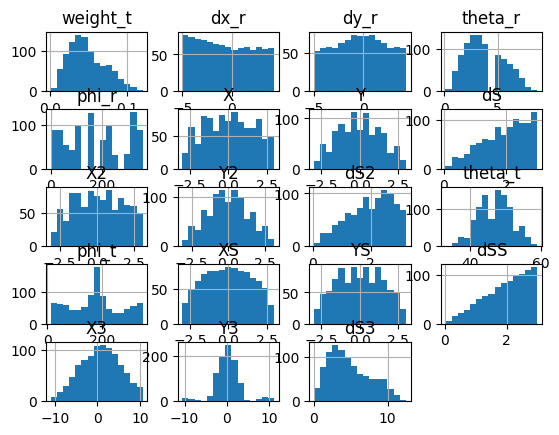

In [20]:
# @title 4.2.2. 信号がセンサーにたどり着く事象の分布
df2=df_advance[df_advance["dSS"]<3]
df2.hist(bins=15,weights=df2["weight_t"])
print(df2.sum())


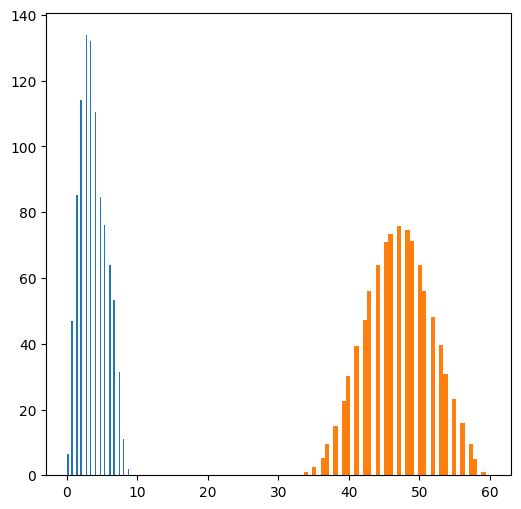

In [21]:
# @title 4.2.3. 信号がセンサーにたどり着く事象の角度分布
fig, ax = plt.subplots(figsize=(6, 6))
ax.hist(df_advance["theta_r"],bins=50,weights=df_advance["weight_t"]*(df_advance["dSS"]<3))
ax.hist(df_advance["theta_t"],bins=50,weights=df_advance["weight_t"]*(df_advance["dSS"]<3))
plt.show()

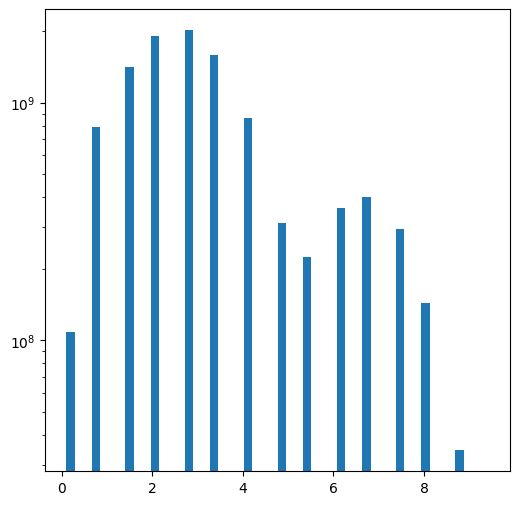

In [29]:
# @title 4.2.4. 信号がセンサーにたどり着く事象の角度分布（断面積の重み付き）

fig, ax = plt.subplots(figsize=(6, 6))
ax.hist(df_advance["theta_r"],bins=50,weights=df_advance["weight_t"]*(df_advance["dSS"]<3)*np.sin(df_advance["theta_t"]/2)**-4)
plt.yscale('log')
plt.show()

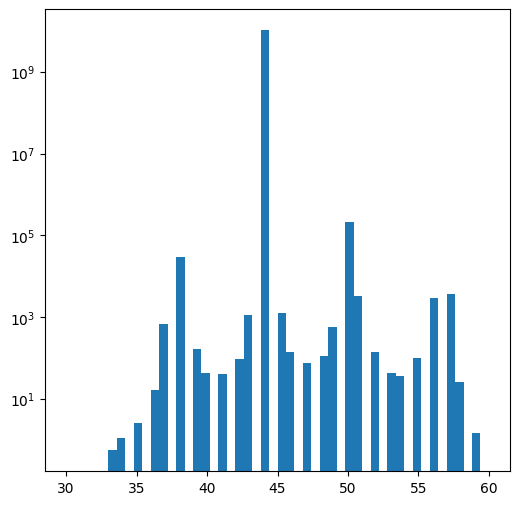

In [30]:
# @title 4.2.5. 信号がセンサーにたどり着く事象の角度分布（断面積の重み付き）
fig, ax = plt.subplots(figsize=(6, 6))
ax.hist(df_advance["theta_t"],bins=50,weights=df_advance["weight_t"]*(df_advance["dSS"]<3)*np.sin(df_advance["theta_t"]/2)**-4)
plt.yscale('log')
plt.show()